In [37]:
import pandas as pd
import ast
import pathlib
from recipe_preprocessor import import_recipes
import seaborn as sns
from typing import List

# 1. Ingredient weighting
1. Drop all rows except ingredients and recipe ID
2. Parse ingredients as a list
3. Explode keeping ID
4. Group by recipe ID and count unique ingredient pairs

## 1.1 Parse the Ingredients column as a tuple

In [3]:
recipe_path: pathlib.Path = pathlib.Path("./data/recipes.csv")

recipes: pd.DataFrame = import_recipes(recipe_path)

## 1.2 Generate unique IDs for each ingredient

In [4]:
# explode on ingredients column to get one row per ingredient
exploded_ingredients = recipes.explode("RecipeIngredientParts")["RecipeIngredientParts"]

# get unique ingredients and reset index to extract their value
ingredient_ids = list(exploded_ingredients.value_counts().index)

In [5]:
num_ingredients = len(ingredient_ids)

## 1.3 Create a relationship matrix

In [6]:
import numpy as np
from typing import Tuple

ingredient_relationships = np.zeros((num_ingredients, num_ingredients))

ingredient_relationships

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 1.4 Map ingredients to IDs

In [7]:
def ingredient_to_id(ingredient: str) -> int:
    try:
        return ingredient_ids.index(ingredient)
    except KeyError:
        return -1


def ingredient_tuple_to_ids(ingredients: Tuple[str]) -> Tuple[int]:
    ingredient_ids = []

    for ingredient in ingredients:
        ingredient_ids.append(ingredient_to_id(ingredient))

    return tuple(ingredient_ids)


recipes["IngredientsIDs"] = recipes["RecipeIngredientParts"].apply(
    ingredient_tuple_to_ids
)

## 1.5 Count co-usage of ingredients

In [40]:
import itertools


def evaluate_cousage(ingredients: List[str]):
    global ingredient_relationships

    # get all combinations of ingredients in the array
    combinations = itertools.combinations(ingredients, 2)

    # for each pairing
    for combination in combinations:

        ingredient_relationships[min(combination)][max(combination)] += 1


recipes["IngredientsIDs"].apply(evaluate_cousage)

0         None
1         None
2         None
3         None
9         None
          ... 
522490    None
522493    None
522495    None
522500    None
522501    None
Name: IngredientsIDs, Length: 72504, dtype: object

In [42]:
ingredient_relationships

array([[5.6560e+03, 4.5628e+04, 4.0772e+04, ..., 4.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 8.6800e+03, 3.2524e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 8.8600e+03, ..., 4.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [51]:
ingredient_df = pd.DataFrame(
    ingredient_relationships, columns=ingredient_ids, index=ingredient_ids
)

In [11]:
ingredient_df.to_csv("ingredient_relationships.csv")

<AxesSubplot: >

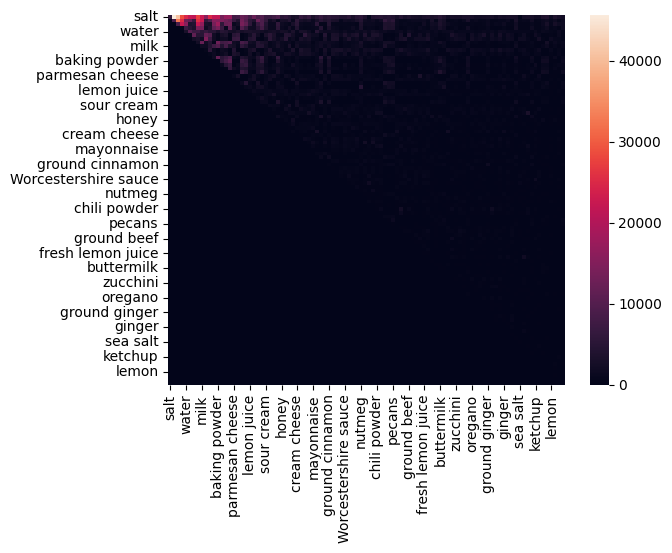

In [55]:
sns.heatmap(ingredient_df.iloc[:100, :100])